# Beta Diversity

## What is beta diversity?

- Beta diversity is a distance or dissimilarity between two samples. Just like we can calculate the (Euclidean) distance between two cities based on their latitude and longitude, we can calculate the distance between two microbial communities based on the composition. However, when investigating microbial communities, there are more dimensions than just latitude and longitude, so the math becomes a little more difficult, and having code to help us calculate the distances is helpful! This chapter will walk you through these steps.

## Why do we care about beta diversity?

Beta diversity gives us ways to quantify how similar or dissimilar two samples are. We can then extrapolate this to comparing microbial communities across metadata variables. For example, are gut microbiome samples generally more similar to other gut microbiome samples or to oral microbiome samples?

## Quantifying beta diversity

### Beta diversity as a pairwise metric

Beta diversity is a **pairwise** metric, meaning each value exists for comparing a pair of samples. Each value is the distance (or dissimilarity) between the two samples.

For example, we can consider the pairwise distances between cities in the Colorado Front Range:

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
cities = ["Boulder", "Denver", "Golden", "Fort Collins", "Colorado Springs"]

# distances are given in miles
distances = np.array([[0, 24, 18, 39, 85],
                      [24, 0, 13, 56, 63],
                      [18, 13, 0, 56, 67],
                      [39, 56, 56, 0, 119],
                      [85, 63, 67, 119, 0]])

distances_df = pd.DataFrame(distances,
                            columns=cities,
                            index=cities)

distances_df

,Boulder,Denver,Golden,Fort Collins,Colorado Springs
Boulder,0,24,18,39,85
Denver,24,0,13,56,63
Golden,18,13,0,56,67
Fort Collins,39,56,56,0,119
Colorado Springs,85,63,67,119,0


In this case, because we have pairwise distances, we can't ask "What's the distance of Boulder?" Likewise, in a microbiome setting, we can't ask "What's the beta diversity of sample A?" Instead, we have to ask the question relative to another city/sample. For example, we can ask "What's the distance from Boulder to Fort Collins?" or "What's the the beta diversity between samples A and B?"

We can view distance matrices as heatmaps for a nice visual. You can see below that the color of each square represents the distance between the two corresponding cities. 

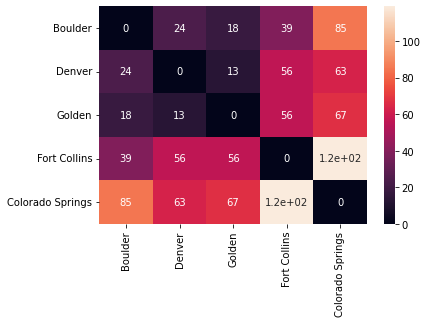

In [11]:
sns.heatmap(distances_df, annot=True)
plt.show()

### Quantitative vs qualitative beta diversity metrics

Some beta diversity metrics look at what taxa are present, but others look at how much of each taxon is there. These are referred to as qualitative and quantitative metrics, respectively. Two common examples are Jaccard distance and Bray-Curtis distance.

**Jaccard distance** is typically used on presence-absence data, and it is the portion of detected taxa that are shared between samples. The equation to calculate Jaccard distance can be seen below, where $J(A,B)$ is the number of taxa shared between the two samples divided by the total number of unique taxa in the two samples.
$$J(A,B) = 1 - \frac{A \cap B}{A \cup B}$$

- Note: if all taxa are shared between the two samples, Jaccard distance will be 0, regardless of the number of taxa. This is why Jaccard is considered a qualitative metric.

**Bray-Curtis distance**, however takes taxa abundances into account. The equation to calculate Bray-Curtis distance can be seen below, where the Bray-Curtis distance between samples A and B is the sum of difference between taxon $i$ in samples A and B divided by the total abundance of taxon $i$ across both samples for all taxa present in the two samples.

$$BC(A,B) = \sum_{i=1}^n \frac{|x_{A,i}-x_{B,i}|}{|x_{A,i}|+|x_{B,i}|}$$

- Q: What happens when there is no difference between the abundances of any taxa in samples A and B?
  - A: The numerator of all terms is 0, meaning that the Bray-Curtis distance is 0!
- Note: Even if all taxa are shared, if they have different abundances, Bray-Curtis distance will not be zero! This is why it can be considered a quantitative metric.

### A simple example

Let's consider an example where we've collected data on how many cats, fish, and bird that Will, Micaela, and Quinn have as pets.

In [12]:
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

In [13]:
a = [1, 0, 3]
b = [9, 0, 3]
c = [0, 2, 0]

pet_types = ["cats", "fish", "birds"]
names = ["Will", "Micaela", "Quinn"]

pets = pd.DataFrame([a,b,c],
                     columns=pet_types,
                     index=names)
pets

,cats,fish,birds
Will,1,0,3
Micaela,9,0,3
Quinn,0,2,0


**Stop here to answer these questions!**
- Q: From looking at the data, what would you expect the Jaccard distance between Will and Micaela to be? 
- What about the Jaccard distance from Will to Quinn? 
- Will Jaccard(Will, Micaela) = BC(Will, Micaela) ?

Let's investigate:

In [14]:
def create_and_show_dist_mat(data, ids, metric, annot=False):
    """
    This function makes a distance matrix and shows a heatmap of it.
    
Parameters
    ----------
    data : pd.DataFrame or NumPy array/matrix
        The data to calculate the distance matrix from.
    ids : list
        The list of sample IDs
    metric: str
        The distance metric to be used when creating the distance matrix.
        See https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        for list of compatible metrics
    annot: Bool
        Provide True if the distances should be written in the heatmap.
        
    Returns
    -------
    dist: pd.DataFrame
        The generated distance matrix
    """
    dist = squareform(pdist(data, metric))
    dist = pd.DataFrame(dist,
                        columns=ids,
                        index=ids)
    
    ax = sns.heatmap(dist, linewidths=1, annot=annot)
    ax.set_title(f"{metric} distance")
    plt.show()
    return dist

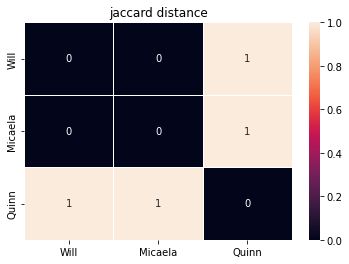

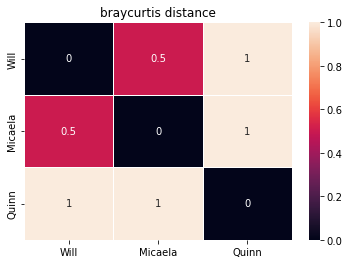

In [15]:
presence_absence_pets = pets.apply(lambda x: x > 0)
jaccard = create_and_show_dist_mat(presence_absence_pets, names, 
                                   metric="jaccard", annot=True)

bray_curt = create_and_show_dist_mat(pets, names, 
                                     metric="braycurtis", annot=True)

**Answers:**

- Jaccard distance from Will to Micaela is 0, since they share the same types of pets
- Jaccard distance from Will to Quinn is 1, since they share none of the same types of pets
- Jaccard(Will,Micaela) is not equal to BC(Will,Micaela)! This is because Jaccard only cares that they both have cats and birds, but Bray-Curtis is taking into account the fact that Micaela has 9 cats while Will only has 1.

### A more complex example

For a more complex example, let's imagine we look for common ingredients in 10 people's shopping carts at the grocery store...

In [16]:
foods = ["apples", "bananas",
         "broccoli","spinach",
         "chicken", "beef",
         "milk", "orange juice","apple juice",
         "cookies"
]

people = [f"Person {x}" for x in np.arange(1,11)]

# make some sparse data
data = sparse.random(10,10, density=0.5, random_state=42)
# turn that data to integers from 1 to 10
data = round((data*10))

# make a dataframe where rows are people
# and columns are foods
data = pd.DataFrame(data.A,
                    columns=foods,
                    index=people)

#convert to integers
data = data.astype(int)

data

,apples,bananas,broccoli,spinach,chicken,beef,milk,orange juice,apple juice,cookies
Person 1,1,4,0,7,2,0,0,8,9,3
Person 2,0,7,0,7,0,0,0,0,3,0
Person 3,0,8,9,0,7,0,4,6,0,0
Person 4,0,9,0,6,0,7,0,7,2,2
Person 5,6,0,0,1,9,0,0,0,0,0
Person 6,9,4,1,9,6,2,7,0,6,2
Person 7,0,6,0,0,0,0,6,4,0,9
Person 8,5,0,4,0,1,0,0,10,0,0
Person 9,0,4,5,0,0,0,0,0,3,0
Person 10,5,9,0,7,3,0,1,0,0,0


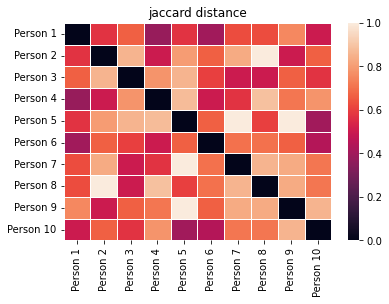

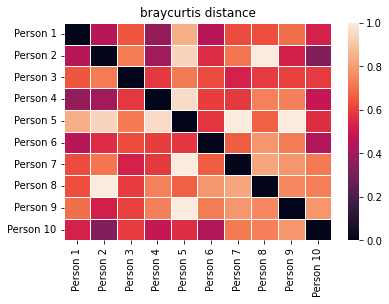

In [17]:
presence_absence_data = data.apply(lambda x: x > 0)
jaccard = create_and_show_dist_mat(presence_absence_data, people, metric="jaccard")

bray_curt = create_and_show_dist_mat(data, people, metric="braycurtis")

These look pretty similar, but they aren't exactly the same. 

For example, look at the color for the distance between individuals 1 and 5. Jaccard gives them a moderate distance (\~0.5) because they share roughly half of the same items in their carts, but Bray-Curtis gives them a high distance (\~0.9) because they have very different quantities of each item in their carts. Specifically, both have apples, but Person 1 has 1 whereas Person 5 has 6. 

### UniFrac

One issue with Bray-Curtis and Jaccard distances is that they don't take phylogeny into account. For example, in our grocery cart study, if someone traded out a gala apple for a granny smith apple, Jaccard and Bray-Curtis would pick that up as the same difference as switching the gala apple for a spatula. There's no context of how related two taxa are. 

Thinking about this in terms of bacteria, we know that *Bifidobacterium longum* is more similar to *Bifidobacterium brevis* than it is to *Escherichia coli*. Shouldn't our distance metrics reflect this knowledge?

This is why microbiome studies will often use UniFrac distances! UniFrac distances (including weighted and unweighted UniFrac) incorporate phylogeny by quantifying the length of shared branches in the phylogenetic tree between samples. 

Unweighted UniFrac, a qualitative metric (similar to Jacccard distance), is the sum of the shared branch length between two samples divided by the total branch length between the two samples. An equation for unweighted UniFrac can be seen below.

$$Unweighted\ UniFrac = 1 - \frac{\sum shared\ branch\ lengths}{\sum total\ branch\ lengths}$$

- **Q:** What happens as the shared branch lengths between two samples approaches the total branch lengths? 
- **A:** The second term approaches 1, and the distance approaches 0. With two identical samples, the value would be zero.

On the other hand, weighted UniFrac is a quantative metric (similar to Bray-Curtis). Weighted UniFrac is similar to its unweighted counterpart, but it weights each shared branch according to the relative abundance of each taxon.



#### An example

Let's investigate! First, we have to create a phylogenetic tree. Often you will use another program, such as FastTree or SATé-Enabled Phylogenetic Placement (SEPP) to do so, but we've created one for the food example by hand.

The string seen in the code block below is a Newick formatted phylogenetic tree. You can see that around all branches at the same level, there are parentheses to group those branches. We can read this into a `skbio.TreeNode` object using `TreeNode.read()`. Typically, you will be reading a Newick formatted file, and you can just provide the filepath, but we have specified the string here, so it's read using StringIO. We can view this `TreeNode` object in our notebook using `.ascii_art()`, but this might be unmanageable for larger trees, so we recommend using another program, such as [Interactive Tree of Life](https://itol.embl.de/)

In [18]:
from skbio import TreeNode
from skbio.diversity import beta_diversity
from io import StringIO

In [19]:
food_tree_str = """(((apples,bananas)fruit,(broccoli,spinach)vegetables)produce,
                     (chicken,beef)meat,(milk,(orange_juice,apple_juice)juice)beverages,
                     (cookies)sweets)items;"""

food_tree = TreeNode.read(StringIO(food_tree_str))

print(food_tree.ascii_art())

                              /-apples
                    /fruit---|
                   |          \-bananas
          /produce-|
         |         |          /-broccoli
         |          \vegetables
         |                    \-spinach
         |
         |          /-chicken
         |-meat----|
-items---|          \-beef
         |
         |          /-milk
         |-beverages
         |         |          /-orange juice
         |          \juice---|
         |                    \-apple juice
         |
          \sweets-- /-cookies


In the code block below, we set each branch length equal to 1. In reality, each branch can be a different distance, but this keeps our example simple.

In [20]:
for node in food_tree.postorder():
    node.length = 1

Below, we use scikit-bio to calculate the UniFrac distance matrices for our data. Note that unlike with Jaccard and Bray-Curtis, we now need to provide the phylogenetic tree. 

This returns objects of the scikit-bio's `DistanceMatrix` class. This is different from when we calculated Jaccard and Bray-Curtis distance using SciPy's `pdist` function, which returns an array that we turned into a square numpy array using the `squareform` function. If we just call the `DistanceMatrix` object by typing u_uni (such as in line 17 of the code below), it prints a heatmap of the distance matrix. However, if we want the data, we can call `DistanceMatrix.data` such as in line 16, which returns an array.  

<class 'skbio.stats.distance._base.DistanceMatrix'>
<class 'numpy.ndarray'>


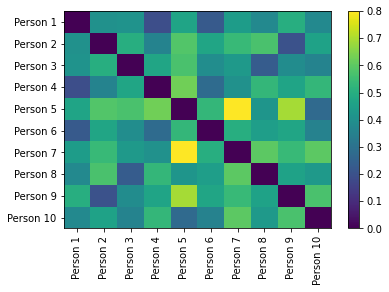

In [21]:
u_uni = beta_diversity(metric="unweighted_unifrac",
                       counts=data,
                       validate=False,
                       tree=food_tree,
                       ids=data.index,
                       otu_ids=data.columns)

w_uni = beta_diversity(metric="weighted_unifrac",
                       counts=data,
                       validate=False,
                       tree=food_tree,
                       ids=data.index,
                       otu_ids=data.columns)

print(type(u_uni)) # should be DistanceMatrix
print(type(u_uni.data)) # should be a ndarray
u_uni # prints the heatmap

Now, we can look at how Jaccard, Bray-Curtis, Unweighted UniFrac, and Weighted UniFrac compare. 

Do they generally match each other? Are there any distances that are particularly different when using different metrics? Can you deduce why based on the initial data and our phylogenetic tree?

Additionally, note that the left column of plots is for qualitative distance metrics, whereas the right column is for quantitative metrics. Likewise, the top row is non-phylogenetic, whereas the bottom row is phylogenetic.

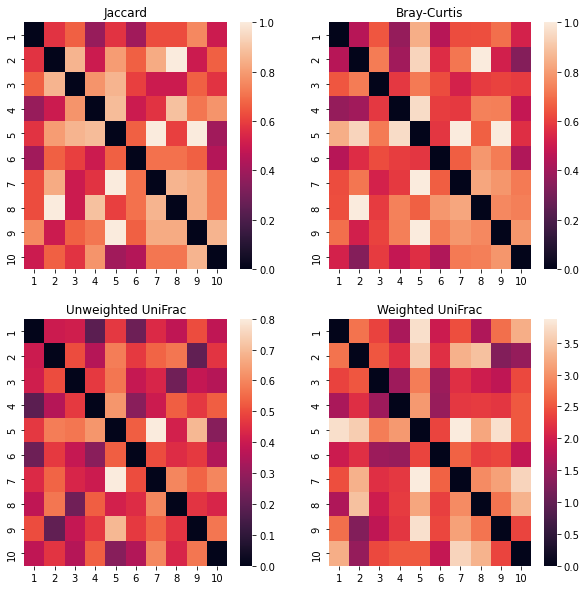

In [22]:
titles = np.array([["Jaccard", "Bray-Curtis"],
                   ["Unweighted UniFrac", "Weighted UniFrac"]])

matrices = np.array([[jaccard, bray_curt],
                    [u_uni.data, w_uni.data]])

fig, ax = plt.subplots(2,2, figsize=(10,10))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_title(titles[i,j])
        sns.heatmap(matrices[i,j], 
                    xticklabels=range(1,11),
                    yticklabels=range(1,11),
                    ax=ax[i,j])

plt.show()

## Stats with beta diversity

### Correlations between distance matrices

How could we quantify how well these distance matrices using different metrics match each other? 

One way would be to look at the correlation between the values across the matrices. This is called a mantel test! We can perform a mantel test using Pearson or Spearman (non-parametric) correlations. 

Often, researchers use a mantel test to see how well beta diversity correlates with some metadata variable, which informs us of the strength of the relationship between microbiome composition and that variable. An example could be looking at the correlation between microbial community composition and pH of the sampling environment. 

Note: There are popular implementations of the mantel test in both Python (via scikit-bio) and R (via the vegan package). The mantel test 

In [23]:
from skbio.stats.distance import DistanceMatrix, mantel, permanova

In [24]:
corr, p, n = mantel(jaccard, bray_curt)
print(f"Correlation coefficient = {corr}, \np = {p}")

Correlation coefficient = 0.7817190130125696, 
p = 0.001


Imagine that we also had the participants in our study give us a score for how much they like meat on a scale from 1 to 10. We could then run a mantel test to see how well that score correlates with beta diversity. Note that we need to create a distance matrix to pass to mantel - we can't run `mantel(DistanceMatrix, list)` because Mantel requires 2 distance matrices! (Feel free to verify this yourself)

In [25]:
# Create our data
like_meat = [5,0,7,7,10,9,0,4,1,6]

# Create a distance matrix for our metadata
# Each entry [i,j] in the matrix corresponds to 
# The difference between like_meat for sample i and like_meat for sample j
# We're effectively taking the Euclidean distance here, but since there are
# only 2 values, we can just take the absolute value of a-b.
meat_distmat = np.zeros(shape=(len(people),len(people)))
for i, num_1 in enumerate(like_meat):
    for j, num_2 in enumerate(like_meat):
        meat_distmat[i,j] = np.abs(num_1-num_2)
        
print("Our distance matrix:\n", meat_distmat, "\n")

# Convert it to type DistanceMatrix
meat_distmat = DistanceMatrix(meat_distmat, ids=people)

dists_and_mats = [("Jaccard", jaccard),
                  ("Bray-Curtis", bray_curt),
                  ("Unweighted UniFrac", u_uni),
                  ("Weighted UniFrac", w_uni)]

# Run mantel on each distance
for dist, matrix in dists_and_mats:
    corr, p, n = mantel(DistanceMatrix(matrix, ids=people), 
                        meat_distmat)
    print(f"{dist} correlation coefficient = {corr}, \np = {p}\n")

Our distance matrix:
 [[ 0.  5.  2.  2.  5.  4.  5.  1.  4.  1.]
 [ 5.  0.  7.  7. 10.  9.  0.  4.  1.  6.]
 [ 2.  7.  0.  0.  3.  2.  7.  3.  6.  1.]
 [ 2.  7.  0.  0.  3.  2.  7.  3.  6.  1.]
 [ 5. 10.  3.  3.  0.  1. 10.  6.  9.  4.]
 [ 4.  9.  2.  2.  1.  0.  9.  5.  8.  3.]
 [ 5.  0.  7.  7. 10.  9.  0.  4.  1.  6.]
 [ 1.  4.  3.  3.  6.  5.  4.  0.  3.  2.]
 [ 4.  1.  6.  6.  9.  8.  1.  3.  0.  5.]
 [ 1.  6.  1.  1.  4.  3.  6.  2.  5.  0.]] 

Jaccard correlation coefficient = 0.18769283253745744, 
p = 0.259

Bray-Curtis correlation coefficient = 0.28011598595536796, 
p = 0.084

Unweighted UniFrac correlation coefficient = 0.36828540678677346, 
p = 0.024

Weighted UniFrac correlation coefficient = 0.299360946507893, 
p = 0.055



### Group difference testing with beta diversity

Similarly, imagine that we also collected data on vegetarianism in our sample population. What if we wanted to test for an association of this categorical variable with microbiome composition? 

We could use a permutational analysis of variance (PERMANOVA), which is a non-parametric version of the ANOVA test that is well-suited for distance matrices. Whereas an ANOVA calculates a p value through the assumption of normality, the PERMANOVA permutes the datapoints and compares the pseduo-F statistic of the actual data to the pseduo-F values that occur with random permutations of the data.

With a PERMANOVA, our metadata should be formatted like a list or a column in a dataframe. We don't need to create a distance matrix in this case, which contrasts the mantel test.

In [26]:
# Use a pd.Series so we can see how the data match up with the index
vegetarian = [False, True, False, False, False,
              False, True, False, True, False]

vegetarian = pd.Series(vegetarian, index=people)

print(vegetarian)

for dist, matrix in dists_and_mats:
    
    print("\n", dist)
    print(permanova(DistanceMatrix(matrix, ids=people), 
          vegetarian))

Person 1     False
Person 2      True
Person 3     False
Person 4     False
Person 5     False
Person 6     False
Person 7      True
Person 8     False
Person 9      True
Person 10    False
dtype: bool

 Jaccard
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      10
number of groups                  2
test statistic             2.007408
p-value                       0.097
number of permutations          999
Name: PERMANOVA results, dtype: object

 Bray-Curtis
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      10
number of groups                  2
test statistic             1.895251
p-value                       0.102
number of permutations          999
Name: PERMANOVA results, dtype: object

 Unweighted UniFrac
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      10
number of groups                  2
test statistic             

### Different results with different distances

There will almost always be different statistical results when using different distance metrics. This does not mean that one distance is better or more accurate than the others. It just means that they tell you different things. When planning an experiment, one should identify the distance metrics that will be used before statistical testing occurs, and all results should be reported. In the case of our vegetarianism example, only unweighted UniFrac had significant results, but that doesn't mean that Jaccard, Bray-Curtis, and Weighted UniFrac results should not be reported. 

## Ordinations

It's often useful to visualize our samples' composition. However, it can be difficult to visualize the whole dataset at once. For example, condsider our gorcery store example - even a simple dataset like that has 10 dimensions! We could maybe get creative with showing multiple 3D scatterplots, but when we scale up to microbiome datasets with hundreds to thousands of taxa, that becomes unmanageable. 

Luckily, dimension reduction techniques exist! Other fields (including classical ecology) often use a technique called Principal Components Analysis (PCA). This allows us to scale a large dataset into just a few important dimensions (or principal components). For our math-inclined readers, these principal components are the eigenvectors of the covariance marix.

Though PCA preserves Euclidean distances well, microbiome data are compositional, and [compositional data do not exist in Euclidean space](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1982.tb01195.x). Thus, we need some dimensionality reduction technique that works with non-Euclidean distances, such as Jaccard, Bray-Curtis, and UniFrac distances.

For non-Euclidean distances, we can use a similar technique called Principal **Coordinates** Analysis (PCoA; components -> coordinates, C -> Co). There are functions to implement PCoA in Python through scikit-bio and R through the vegan package.

In [27]:
from skbio.stats.ordination import pcoa

In [28]:
u_uni_pcoa = pcoa(u_uni, number_of_dimensions=3)
u_uni_coords = u_uni_pcoa.samples

/opt/anaconda3/envs/Int_MEX/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03304581294149358 and the largest is 0.44030598149431005.
  warn(


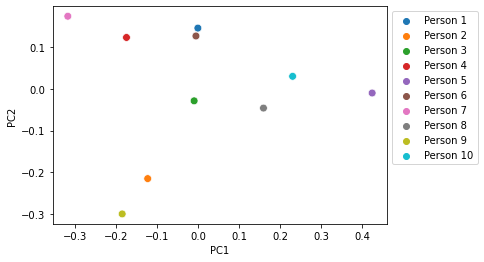

In [29]:
ax = sns.scatterplot(x="PC1", y="PC2", 
                     hue=u_uni_coords.index, 
                     data=u_uni_coords, s=60)

ax.legend(bbox_to_anchor=(1,1))

plt.show()

We can color this ordination according to metadata variables, such as our score for how much each individual likes meat. In this case, we can see that individuals who reported not liking meat tended to be toward the left side of the plot, whereas individuals who reported liking meat tended to be toward the right side of the plot. Through this, we can visualize the results of our mantel test.

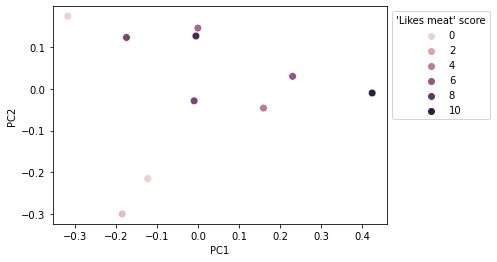

In [30]:
ax = sns.scatterplot(x="PC1", y="PC2", 
                     hue=like_meat, 
                     data=u_uni_coords, s=60)

ax.legend(bbox_to_anchor=(1,1),
          title="'Likes meat' score")

plt.show()

## Clustering

## Real world example

## Interactive example/homework